## This notebook is to explore Scania Dataset, impute the missing values and No dimensionality reduction

**Yasmin Fathy <Fathy.Yasmin@gmail.com>**

**Latest Updates: 28/08/2020**

In [1]:
import pandas as pd
import numpy as np
import os
from pprint import pprint

# to display fully (non-truncated) data-frame
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
#pd.set_option('display.max_colwidth', -1)

#Setup to show all results in jupiter not only the last one:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # revert to 'last_expr' to get only last results

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline
from pprint import pprint

import matplotlib as mpl
#mpl.rcParams['figure.figsize'] = (20,20)
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}
mpl.rc('font', **font)

## Evaluation

In [2]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, precision_score, make_scorer,\
    recall_score, f1_score, precision_recall_curve, log_loss, cohen_kappa_score,roc_curve, auc
from tqdm import tqdm

In [3]:
RANDOM_STATE = 42

**APS Misclasification Cost Function**

In [4]:
def __perform_measure(y_actual, y_hat):
        TP = 0
        FP = 0
        TN = 0
        FN = 0
        y_actual = list(y_actual)
        y_hat = list(y_hat)
        for i in range(len(y_hat)):
            if y_actual[i] == y_hat[i] == 1:
                TP += 1
            if y_hat[i] == 1 and y_actual[i] != y_hat[i]:
                FP += 1
            if y_actual[i] == y_hat[i] == 0:
                TN += 1
            if y_hat[i] == 0 and y_actual[i] != y_hat[i]:
                FN += 1

        return [TP, FP, TN, FN]

def custom_cost_fn_loss(y_actual, y_hat):
        [TP, FP, TN, FN] = __perform_measure(y_actual, y_hat)
        # print(len(list(y_actual)),
        #       len(list(y_hat)))
        # cm = confusion_matrix(list(y_actual), list(y_hat))
        # print(len(cm))
        # print(len(cm[0]))
        # print(cm)
        # FP = cm[0][1]
        # FN = cm[1][0]
        return (500 * FN) + (FP * 10)
    
APS_cost_fn = make_scorer(custom_cost_fn_loss, greater_is_better=False)

### ML Model Evalution

- **y** : original label in the testing-set
- **y_predict**: predicted label from the ML algorithm
- **y_predict_prob**: probability output of the algorithm about the minority class

**Plotting the precision, recall curve**

In [5]:
def plot_precession_recall_curve(y, y_predict, alg_name):
    fpr, tpr, thresholds = precision_recall_curve(y, y_predict)
    roc_auc = auc(fpr, tpr)


    plt.figure()
    plt.plot(fpr, tpr, color='red', label='Precision Recall curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Precision Recall curve  '+ str(alg_name))
    plt.legend(loc="lower right")
    plt.show();

In [6]:
def plot_roc_auc_curve(y, y_predict, alg_name):
    fpr, tpr, thresholds = roc_curve(y, y_predict)
    roc_auc = auc(fpr, tpr)


    plt.figure()
    plt.plot(fpr, tpr, color='red', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show();

**Evaluating the results using a set of metrics**

In [7]:
def model_evaluaiton(y, y_predict, alg_name):        
            print(classification_report(y, list(y_predict)))
            cm = confusion_matrix(y, list(y_predict))
            print(cm)
            print("Accuracy:", accuracy_score(y, y_predict))
            print("roc_auc_score:", roc_auc_score(y, y_predict))
            print("precision_score:", precision_score(y, y_predict))
            print("recall_score:", recall_score(y, y_predict))
            print("f1_score:", f1_score(y, y_predict))
            FP = cm[0][1]
            FN = cm[1][0]
            print("CM: FP", FP)
            print("CM: FN", FN)
            print("APS Cost = ", (500 * FN) + (FP * 10))
            plot_precession_recall_curve(y, y_predict, alg_name)
            plot_roc_auc_curve(y, y_predict, alg_name)

**Finding the threshold that minimises the misclassification of the minority class i.e. class = 1 and apply the best threshold as post-processing steps**

In [8]:
def find_cut_off(y, y_predict_prob):
    fpr, tpr, thresholds = precision_recall_curve(y, y_predict_prob)
    min_cost = np.inf
    best_threshold = 0.5
    costs = []
    for threshold in tqdm(thresholds):
        #y_pred_threshold = np.where(scores > threshold, 0, 1)
        y_pred_threshold = y_predict_prob > threshold
        tn, fp, fn, tp = confusion_matrix(y, y_pred_threshold).ravel()
        cost = 10*fp + 500*fn
        costs.append(cost)
        if cost < min_cost:
            min_cost = cost
            best_threshold = threshold
    print("Best threshold: {:.4f}".format(best_threshold))
    print("Min cost: {:.2f}".format(min_cost))
    return best_threshold
    

---

## Read training and testing files

In [9]:
# data_dir ="ScaniaDataset/dimReduction/"
# df_train = pd.read_csv(data_dir+"pca_aps_mean_failure_train_set.csv")
# df_test =  pd.read_csv(data_dir+"pca_aps_mean_failure_test_set.csv")

data_dir ="ScaniaDataset/imputation/"
df_train = pd.read_csv(data_dir+"imp_aps_mean_failure_training_set.csv")
df_test =  pd.read_csv(data_dir+"imp_aps_mean_failure_test_set.csv")

In [10]:
df_train["class"].value_counts()

df_test["class"].value_counts()

0    59000
1     1000
Name: class, dtype: int64

0    15625
1      375
Name: class, dtype: int64

In [11]:
df_train.head()
df_test.head()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000,class
0,0.027925,0.003496,9.999998e-01,3.261769e-08,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000163,0.007996,0.038972,0.015907,0.001463,0.0,0.034368,0.0,0.000000,0.0,0.000000,0.00000,0.035022,0.029911,0.022660,0.044285,0.0,0.0,0.0,0.0,0.001274,0.002297,0.0,0.0,0.0,0.0,0.000000,0.003754,0.033205,0.001436,0.007229,0.0,0.000531,0.000465,2.893584e-04,0.000271,5.000101e-03,0.011813,3.681733e-05,1.021497e-07,0.0,0.0,0.010000,0.008791,0.007444,0.007777,0.012332,0.035479,0.058892,0.000250,0.000000,0.000000,0.034739,0.000000,0.000033,0.000133,0.000979,0.034368,0.030469,0.021086,0.017480,0.252354,0.269627,0.228244,0.232853,0.216434,0.420683,0.444702,0.461499,0.172130,0.027925,0.034739,0.034739,0.035415,0.043479,0.001693,0.446972,0.527780,0.041502,0.0,0.050171,2.329835e-10,0.004486,0.000000,0.037208,0.0,0.016536,0.000046,0.026223,0.0,0.000000,0.000000e+00,0.001244,0.007709,0.027562,0.019164,0.002982,0.001486,4.417780e-05,2.562819e-08,0.000484,0.034739,0.000645,0.012483,0.002794,5.815179e-03,0.012301,0.005728,0.010592,0.012140,0.002044,0.000074,0.0,0.000584,0.001000,0.050517,0.001163,0.000000,2.780107e-02,0.000000,0.001868,0.044143,0.010630,0.006391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.021296,0.045829,0.094192,0.000000e+00,0.000000,0.040779,0.057779,0.032041,0.014773,0.000000,0.000000,0.0,0.0,0.002118,0.023069,0.032751,0.012881,0.017378,0.015918,0.013067,7.421784e-03,8.179508e-03,1.073013e-02,0.001321,0.003800,0.000000,0.000000,0.000000,0
1,0.012036,0.003496,0.000000e+00,2.220573e-05,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000080,0.003646,0.018302,0.008157,0.001787,0.0,0.018766,0.0,0.000012,0.0,0.000000,0.00000,0.018180,0.017407,0.013917,0.013244,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000572,0.006052,0.004078,0.000952,0.0,0.000725,0.001724,9.689357e-04,0.000287,8.208840e-03,0.004005,2.279950e-04,1.532245e-07,0.0,0.0,0.005920,0.003845,0.003575,0.004178,0.005457,0.007219,0.008733,0.016044,0.002785,0.000108,0.018907,0.000217,0.001481,0.000449,0.006856,0.018766,0.015318,0.015317,0.008575,0.260487,0.274495,0.279667,0.353789,0.391507,0.420683,0.444702,0.461499,0.006459,0.012036,0.018907,0.018907,0.019221,0.017698,0.006416,0.955934,0.005705,0.019802,0.0,0.000000,2.215927e-05,0.004277,0.000222,0.016250,0.0,0.011610,0.000000,0.000000,0.0,0.000000,6.494771e-07,0.001039,0.006944,0.010922,0.004667,0.001095,0.000688,1.538530e-06,2.219349e-05,0.000000,0.018907,0.000645,0.007340,0.001814,3.577230e-03,0.008252,0.003646,0.004847,0.004085,0.000710,0.000014,0.0,0.000823,0.001667,0.023635,0.007970,0.000294,1.011367e-03,0.000352,0.001392,0.018224,0.007440,0.002963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011535,0.019709,0.017052,0.000000e+00,0.000000,0.020787,0.024761,0.009800,0.006837,0.000000,0.000000,0.0,0.0,0.002630,0.020862,0.028186,0.008862,0.008391,0.005407,0.004716,3.019031e-03,4.272

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000,class
0,0.000022,0.000000,9.386557e-09,1.397901e-09,0.0,0.0,0.0,0.0,0.0,0.000042,2.069654e-05,0.000022,0.000020,0.000000,0.000000,0.000000,0.000054,0.0,0.000000,0.0,0.000044,0.000042,0.000082,0.000078,0.001428,0.000018,0.0,0.0,0.000000,0.0,0.000073,0.000223,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000126,1.062436e-07,0.000193,0.000096,0.000005,0.000004,0.000002,0.000013,1.777389e-05,0.000075,0.000001,0.0,0.000038,0.000022,0.000009,0.000010,0.000008,0.000027,0.000005,0.000005,0.000002,0.000000,0.000645,0.000010,0.000020,0.000005,0.000000,0.000054,0.000099,0.002396,0.000076,0.213954,0.245177,0.304878,0.353789,0.391507,0.420683,0.444702,0.461499,0.106995,0.000022,0.000645,0.000645,0.000992,0.000054,0.000017,0.101243,0.102421,0.000089,0.0,0.000122,0.000000e+00,0.000280,0.0,0.000042,0.000000,0.000106,0.000046,0.000409,0.0,1.378075e-07,9.420836e-05,0.000049,0.000008,0.000013,5.271890e-07,1.206865e-07,0.000000,0.000000,9.319341e-10,0.000024,0.000645,0.000000,0.001847,0.000032,7.811493e-07,6.128916e-07,0.000012,0.000001,0.000104,0.000178,0.000130,0.0,0.000024,0.000057,0.000065,0.000029,0.000000,0.000000e+00,0.0,0.000000,0.000055,0.000157,0.000636,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.000116,0.000000,0.000000,1.731773e-07,0.000011,0.000047,0.000101,0.000002,0.000007,0.000000,0.000001,0.0,0.0,0.000000,0.004391,0.001087,0.000100,0.000032,0.000014,0.000004,0.000004,0.000011,0.000002,7.359084e-07,0.000000,0.000000,0.0,0.0,0
1,0.000030,0.000000,3.191429e-08,4.659671e-09,0.0,0.0,0.0,0.0,0.0,0.000000,3.268794e-06,0.000070,0.000039,0.000000,0.000000,0.000000,0.000071,0.0,0.000011,0.0,0.000000,0.000000,0.000165,0.000149,0.000304,0.000050,0.0,0.0,0.000000,0.0,0.000015,0.000703,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000001,0.000156,0.000000e+00,0.000028,0.000010,0.000004,0.000028,0.000007,0.000007,1.718865e-04,0.000000,0.000000,0.0,0.000054,0.000015,0.000011,0.000007,0.000007,0.000007,0.000043,0.000022,0.000006,0.000003,0.000243,0.000010,0.000007,0.000047,0.000000,0.000071,0.000112,0.000457,0.000069,0.213954,0.245177,0.304878,0.353789,0.391507,0.420683,0.444702,0.461499,0.022483,0.000030,0.000243,0.000243,0.000258,0.000068,0.000000,0.037088,0.038428,0.000115,0.0,0.000148,2.329835e-10,0.000187,0.0,0.000051,0.000000,0.000140,0.000000,0.000572,0.0,0.000000e+00,6.836601e-08,0.000074,0.000036,0.000021,1.728625e-05,3.620594e-07,0.000000,0.000000,1.630885e-09,0.000109,0.000243,0.000000,0.002624,0.000064,2.473639e-06,8.250464e-06,0.000009,0.000005,0.000130,0.000169,0.000050,0.0,0.000088,0.000281,0.000096,0.000033,0.000000,0.000000e+00,0.0,0.000000,0.000066,0.000175,0.000227,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.000120,0.000000,0.000000,6.291058e-07,0.000012,0.000040,0.000094,0.000082,0.000030,0.000056,0.000009,0.0,0.0,0.000000,0.000027,0.001232,0.000134,0.00003

----

## ML Predictive models on the original data: No data generation included

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.linear_model import LogisticRegression

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb


In [13]:
#scoring_fn = "f1_weighted"
scoring_fn = APS_cost_fn

In [14]:
y_train = df_train['class']
y_test = df_test['class']

X_train = df_train.drop(['class'], axis=1)
X_test = df_test.drop(['class'], axis=1)

In [15]:
len(X_train)
len(X_test)

60000

16000

### Logistic Regression

In [16]:
# LR_hyperparameters = dict(C=[0.01, 1, 10, 100],
#                                max_iter=[6000])  # hyperparameter options

# # Best options obtained from running the params mentioned above
#LR_hyperparameters = dict(C=[1], max_iter=[6000])  # hyperparameter options => best if PCA is used
LR_hyperparameters = dict(C=[10], max_iter=[6000])  # hyperparameter options

In [17]:
LR_clf = GridSearchCV(LogisticRegression(class_weight="balanced", random_state=RANDOM_STATE),
                               param_grid=LR_hyperparameters, cv=5,
                               verbose=2, scoring=scoring_fn, n_jobs=-1)

LR_best_model = LR_clf.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   16.4s remaining:   10.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.6s finished


**Evaluating on Testing-set**

Best estimator:  LogisticRegression(C=10, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=6000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     15625
           1       0.48      0.93      0.63       375

    accuracy                           0.97     16000
   macro avg       0.74      0.95      0.81     16000
weighted avg       0.99      0.97      0.98     16000

[[15243   382]
 [   26   349]]
Accuracy: 0.9745
roc_auc_score: 0.9531093333333334
precision_score: 0.4774281805745554
recall_score: 0.9306666666666666
f1_score: 0.6311030741410488
CM: FP 382
CM: FN 26
APS Cost =  16820


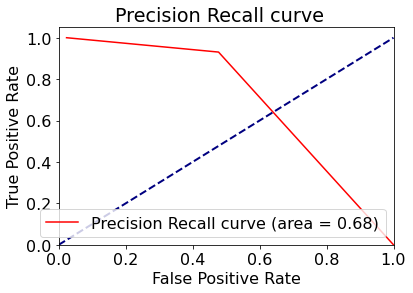

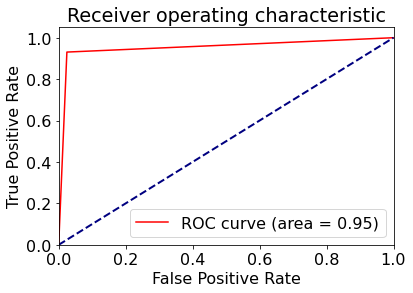

In [18]:
print("Best estimator: ", LR_best_model.best_estimator_)
# X = X.values.reshape(-1, 1)
LR_predict_test = LR_best_model.predict(X_test)
LR_pre_prob_test = LR_best_model.predict_proba(X_test)

model_evaluaiton(y_test, LR_predict_test,"")

**Finding the threshold and then evaluate**
- y_predict_prob_1 : classifier probability's output for minority class

In [19]:
LR_y_predict_prob_1 = LR_pre_prob_test[:,1]
LR_best_th = find_cut_off(y_test, LR_y_predict_prob_1)

100%|██████████| 15982/15982 [09:39<00:00, 27.58it/s]

Best threshold: 0.3413
Min cost: 14330.00


In [20]:
LR_best_th

0.3412506982351115

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     15625
           1       0.38      0.95      0.54       375

    accuracy                           0.96     16000
   macro avg       0.69      0.96      0.76     16000
weighted avg       0.98      0.96      0.97     16000

[[15042   583]
 [   17   358]]
Accuracy: 0.9625
roc_auc_score: 0.9586773333333334
precision_score: 0.3804463336875664
recall_score: 0.9546666666666667
f1_score: 0.5440729483282675
CM: FP 583
CM: FN 17
APS Cost =  14330


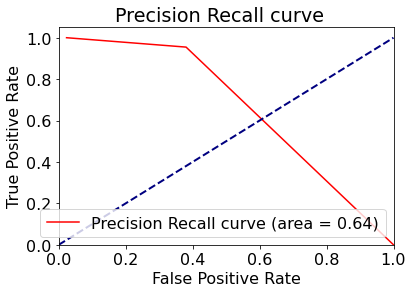

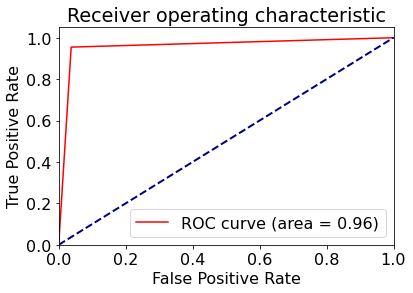

In [21]:
LR_predict_test_th = LR_pre_prob_test[:,1] > LR_best_th

model_evaluaiton(y_test, LR_predict_test_th, "")

**Just example to prove the point of how the threshold works**

In [42]:
(1.0-LR_best_th)
lr_th = round((1.0-LR_best_th),3)
lr_th 

0.6587493017648884

0.659

0.6587493017648884

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     15625
           1       0.38      0.95      0.54       375

    accuracy                           0.96     16000
   macro avg       0.69      0.96      0.76     16000
weighted avg       0.98      0.96      0.97     16000

[[15040   585]
 [   17   358]]
Accuracy: 0.962375
roc_auc_score: 0.9586133333333333
precision_score: 0.3796394485683987
recall_score: 0.9546666666666667
f1_score: 0.5432473444613051
CM: FP 585
CM: FN 17
APS Cost =  14350


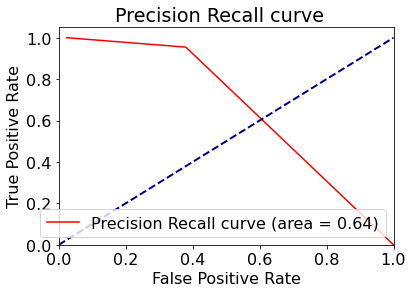

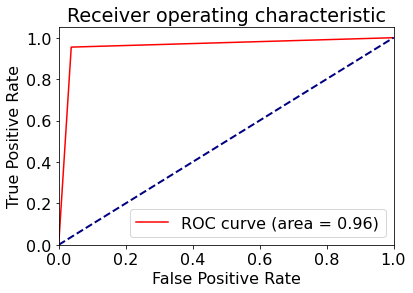

In [43]:
# LR_predict_test_th_2 = LR_pre_prob_test[:,1] >= LR_best_th
# LR_predict_test_th_2 = LR_pre_prob_test[:,0] < (1.0-LR_best_th)
LR_predict_test_th_2 = LR_pre_prob_test[:,0] < lr_th

(1.0-LR_best_th)
model_evaluaiton(y_test, LR_predict_test_th_2, "")

**Evaluate on Training-set**

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     59000
           1       0.38      0.95      0.54      1000

    accuracy                           0.97     60000
   macro avg       0.69      0.96      0.76     60000
weighted avg       0.99      0.97      0.98     60000

[[57439  1561]
 [   54   946]]
Accuracy: 0.9730833333333333
roc_auc_score: 0.9597711864406779
precision_score: 0.37734343837255685
recall_score: 0.946
f1_score: 0.5394924436840604
CM: FP 1561
CM: FN 54
APS Cost =  42610


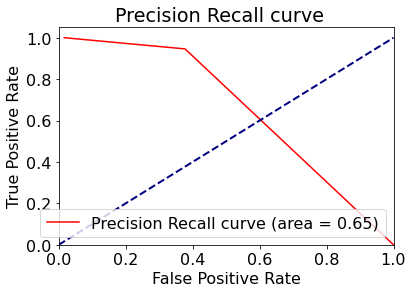

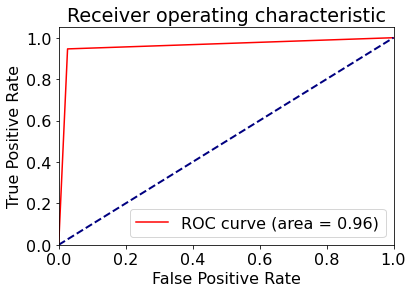

In [24]:
LR_predict_train = LR_best_model.predict(X_train)
LR_pre_prob_train = LR_best_model.predict_proba(X_train)

model_evaluaiton(y_train, LR_predict_train, "")

### Random Forest

In [25]:
# RF_hyperparameters = {
#             'n_estimators': [50, 100, 250],
#              'max_features': ['auto', 'sqrt', 'log2'],
#             # 'max_depth': [5, 6, 8, None],
#             'max_depth': [5, 6, 8],
#             'criterion': ['gini', 'entropy']}

# ## Best Params based on running the previous range of hyperparameter => when PCA is used
# RF_hyperparameters = {
#                       'n_estimators': [250],
#                        'max_depth': [5],
#                       'criterion': ['entropy']}


## Best Params based on running the previous range of hyperparameter
RF_hyperparameters = {
                      'n_estimators': [250],
                       'max_depth': [5],
                      'criterion': ['gini']}

In [26]:
RF_clf = GridSearchCV(RandomForestClassifier(class_weight="balanced", random_state= RANDOM_STATE),
                               param_grid=RF_hyperparameters, cv=5,
                               verbose=2, scoring=scoring_fn, n_jobs=-1)

RF_best_model = RF_clf.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   33.9s remaining:   22.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   34.0s finished


**Evaluating on Testing-set**

Best estimator:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     15625
           1       0.37      0.97      0.54       375

    accuracy                           0.96     16000
   macro avg       0.69      0.96      0.76     16000
weighted avg       0.98      0.96      0.97     16000

[[15014   611]
 [   12   363]]
Accuracy: 0.9610625
roc_auc_score: 0.964448
precision_score: 0.37268993839835

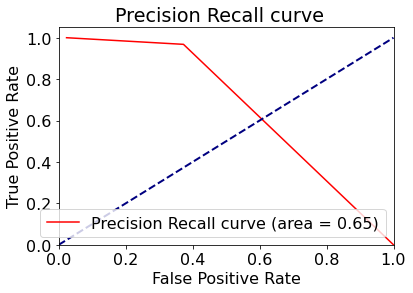

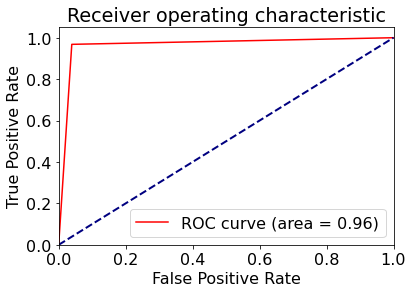

In [27]:
print("Best estimator: ", RF_best_model.best_estimator_)
# X = X.values.reshape(-1, 1)
RF_predict_test = RF_best_model.predict(X_test)
RF_pre_prob_test = RF_best_model.predict_proba(X_test)
model_evaluaiton(y_test,RF_predict_test, "")

**Finding the threshold and then evaluate**
- y_predict_prob_1 : classifier probability's output for minority class

In [28]:
RF_y_predict_prob_1 = RF_pre_prob_test[:,1]
RF_best_th = find_cut_off(y_test, RF_y_predict_prob_1)

100%|██████████| 2690/2690 [01:34<00:00, 28.57it/s]

Best threshold: 0.4381
Min cost: 10790.00


              precision    recall  f1-score   support

           0       1.00      0.96      0.98     15625
           1       0.35      0.98      0.52       375

    accuracy                           0.96     16000
   macro avg       0.68      0.97      0.75     16000
weighted avg       0.98      0.96      0.97     16000

[[14946   679]
 [    8   367]]
Accuracy: 0.9570625
roc_auc_score: 0.9676053333333334
precision_score: 0.3508604206500956
recall_score: 0.9786666666666667
f1_score: 0.5165376495425755
CM: FP 679
CM: FN 8
APS Cost =  10790


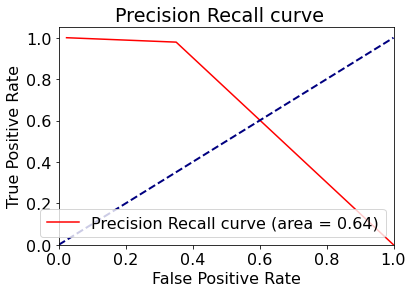

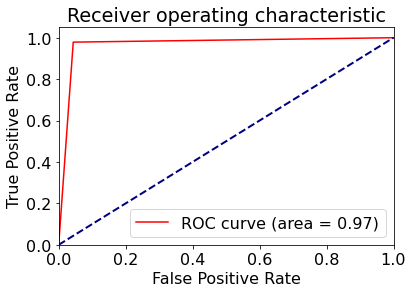

In [53]:
RF_predict_test_th = RF_pre_prob_test[:,1] > RF_best_th
model_evaluaiton(y_test, RF_predict_test_th, "")

**Just example to prove the point of how the threshold works**

In [45]:
(1.0-RF_best_th)
rf_th = round((1.0-RF_best_th),3)
rf_th

0.561949219837919

0.562

0.561949219837919

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     15625
           1       0.35      0.98      0.52       375

    accuracy                           0.96     16000
   macro avg       0.67      0.97      0.75     16000
weighted avg       0.98      0.96      0.97     16000

[[14945   680]
 [    8   367]]
Accuracy: 0.957
roc_auc_score: 0.9675733333333334
precision_score: 0.35052531041069723
recall_score: 0.9786666666666667
f1_score: 0.5161744022503516
CM: FP 680
CM: FN 8
APS Cost =  10800


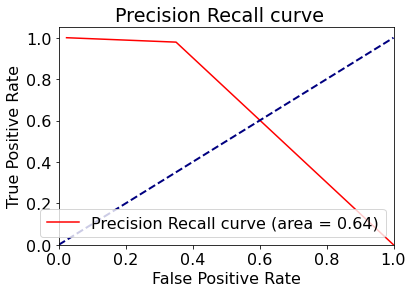

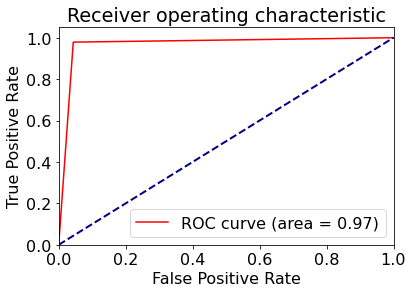

In [54]:
# RF_predict_test_th_2 = RF_pre_prob_test[:,1] >= RF_best_th
# RF_predict_test_th_2 = RF_pre_prob_test[:,0] < (1 - RF_best_th)
RF_predict_test_th_2 = RF_pre_prob_test[:,0] < rf_th

(1 - RF_best_th)
model_evaluaiton(y_test, RF_predict_test_th_2, "")

**Evaluating on Training-set**

Best estimator:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     56636
           1       0.97      0.29      0.44      3364

    accuracy                           0.96     60000
   macro avg       0.96      0.64      0.71     60000
weighted avg       0.96      0.96      0.95     60000

[[56605    31]
 [ 2395   969]]
Accuracy: 0.9595666666666667
roc_auc_score: 0.6437512927538851
precision_scor

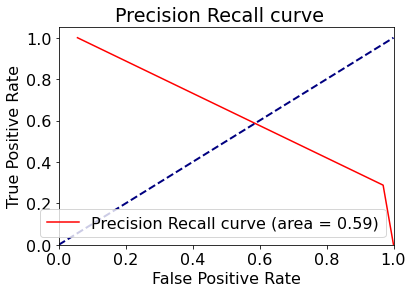

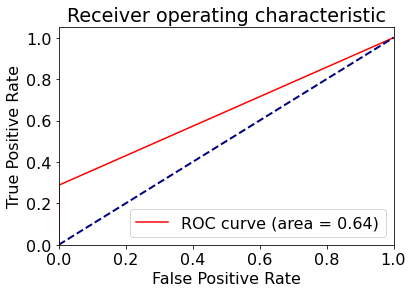

In [32]:
print("Best estimator: ", RF_best_model.best_estimator_)
# X = X.values.reshape(-1, 1)
RF_predict_train = RF_best_model.predict(X_train)
RF_pre_prob_train = RF_best_model.predict_proba(X_train)
model_evaluaiton(RF_predict_train, y_train, "")

## XGBoost

In [33]:
# xg_hyperparameters = {
#                 'max_depth': [3, 4, 5],
#                 'n_estimators': [50, 100],
#                 'learning_rate': [0.1, 0.01, 0.05]
#             }

# best params => when PCA is used
# xg_hyperparameters = {
#                 'max_depth': [5],
#                 'n_estimators': [100],
#                 'learning_rate': [0.1]
#             }

### best params 
xg_hyperparameters = {
                'max_depth': [5],
                'n_estimators': [100],
                'learning_rate': [0.03]
            }

In [34]:
xg_clf = GridSearchCV(estimator=xgb.XGBClassifier(random_state=RANDOM_STATE),
                                   param_grid=xg_hyperparameters, cv=5,
                                   scoring=scoring_fn, n_jobs=-1,verbose=2)

In [35]:
xgbb = xg_clf.fit(X_train, y_train)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.4min remaining:   54.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished


**Evaluating on Testing-set**

Best estimator:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.03, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     15625
           1       0.93      0.66      0.77       375

    accuracy                           0.99     16000
   macro avg       0.96      0.83      0.88     16000
weighted avg       0.99      0.99      0.99     16000

[[15607    18]
 [  129   246]]
Accurac

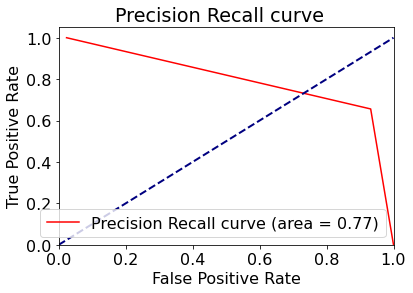

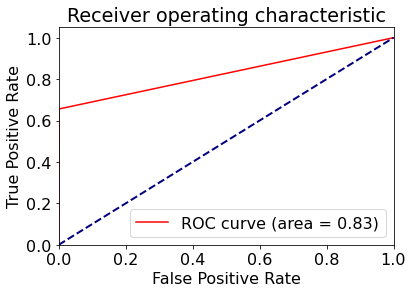

In [36]:
print("Best estimator: ", xgbb.best_estimator_)
# X = X.values.reshape(-1, 1)
xgbb_predict_test = xgbb.predict(X_test)
xgbb_pre_prob_test = xgbb.predict_proba(X_test)
model_evaluaiton(y_test, xgbb_predict_test, "")

**Finding the threshold and then evaluate**
- y_predict_prob_1 : classifier probability's output for minority class

In [37]:
xgbb_y_predict_prob_1 = xgbb_pre_prob_test[:,1]
xgbb_best_th = find_cut_off(y_test, xgbb_y_predict_prob_1)

100%|██████████| 1291/1291 [00:47<00:00, 27.17it/s]

Best threshold: 0.0568
Min cost: 9810.00


              precision    recall  f1-score   support

           0       1.00      0.97      0.98     15625
           1       0.43      0.97      0.60       375

    accuracy                           0.97     16000
   macro avg       0.72      0.97      0.79     16000
weighted avg       0.99      0.97      0.97     16000

[[15144   481]
 [   10   365]]
Accuracy: 0.9693125
roc_auc_score: 0.9712746666666666
precision_score: 0.4314420803782506
recall_score: 0.9733333333333334
f1_score: 0.5978705978705979
CM: FP 481
CM: FN 10
APS Cost =  9810


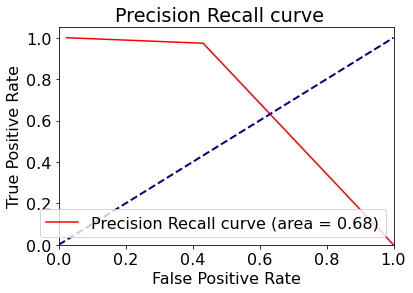

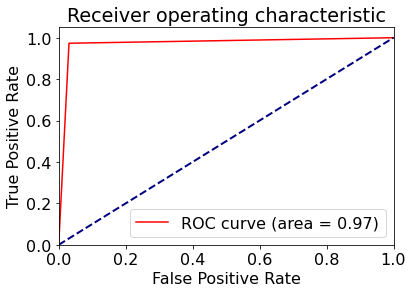

In [38]:
xgbb_predict_test_th = xgbb_pre_prob_test[:,1] > xgbb_best_th

model_evaluaiton(y_test, xgbb_predict_test_th, "")


**Just example to prove the point of how the threshold works**

In [56]:
(1.0-xgbb_best_th)
xg_th = round((1.0-xgbb_best_th),3)
xg_th

0.9432493187487125

0.943

0.9432493187487125

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     15625
           1       0.43      0.97      0.60       375

    accuracy                           0.97     16000
   macro avg       0.72      0.97      0.79     16000
weighted avg       0.99      0.97      0.97     16000

[[15144   481]
 [   10   365]]
Accuracy: 0.9693125
roc_auc_score: 0.9712746666666666
precision_score: 0.4314420803782506
recall_score: 0.9733333333333334
f1_score: 0.5978705978705979
CM: FP 481
CM: FN 10
APS Cost =  9810


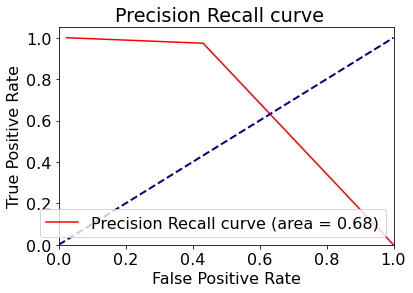

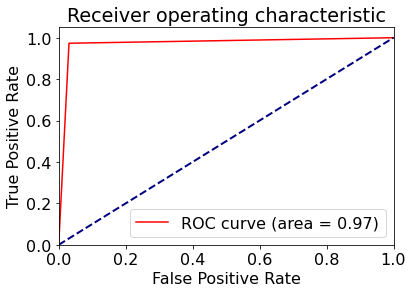

In [57]:
# xgbb_predict_test_th = xgbb_pre_prob_test[:,1] >= xgbb_best_th
# xgbb_predict_test_th = xgbb_pre_prob_test[:,0] < (1 - xgbb_best_th)

xgbb_predict_test_th = xgbb_pre_prob_test[:,0] < xg_th

(1 - xgbb_best_th)
model_evaluaiton(y_test, xgbb_predict_test_th, "")

**Evaluating on Training-set**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59000
           1       0.96      0.76      0.85      1000

    accuracy                           1.00     60000
   macro avg       0.98      0.88      0.92     60000
weighted avg       1.00      1.00      1.00     60000

[[58972    28]
 [  239   761]]
Accuracy: 0.99555
roc_auc_score: 0.8802627118644069
precision_score: 0.9645120405576679
recall_score: 0.761
f1_score: 0.8507546115148127
CM: FP 28
CM: FN 239
APS Cost =  119780


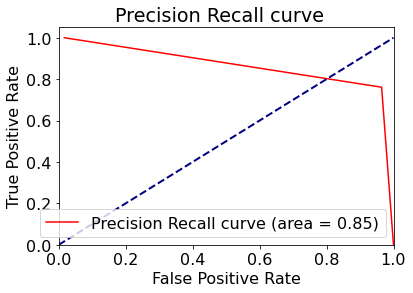

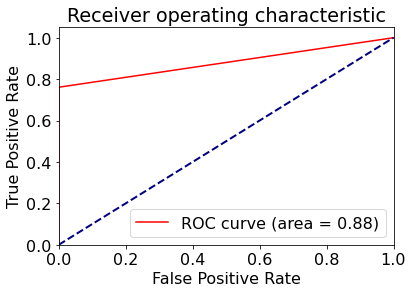

In [41]:
xgbb_predict_train = xgbb.predict(X_train)
xgbb_pre_prob_train = xgbb.predict_proba(X_train)
model_evaluaiton(y_train, xgbb_predict_train ,"")

-----